#### Tree based selection, feature selection with GA and LOSO with an SVM

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from parameter_feature_search import *
import DataProcess as DP
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### We can choose to use just the protocol or just the optional datset

In [36]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [37]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    subject_index = int(fname.split('/')[-1].split('.')[0][-1])
    dp = DP.dataprocess(fname,T=512,stride=512)
    
    #For LOSO, we need subjectID in the final dataframe
    dp.df['subjectID'] = int(subject_index)*np.ones(len(dp.df))
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

In [38]:
len(feature_df.columns)

304

In [39]:
feature_df.to_csv("Features_df_with_subject_protocol.dat",index=False)

#### Load features dataframe

In [40]:
feature_df = pd.read_csv("Features_df_with_subject_protocol.dat")

In [41]:
Y = feature_df['activityID']
X = feature_df.drop(['activityID','subjectID'],axis=1)

#### Scale the input matrix and generate classification labels from the target column

In [42]:
sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X),columns=X.columns)
le = LabelEncoder()
labels = le.fit_transform(Y)

#### Set up inputs for initial hyperparameter search function

In [48]:
model = SVC()

parameters = {
    'classify__C': (1,10,50,80,100,150),
    'classify__degree': (1,3,4),
    'classify__kernel':("poly","rbf","sigmoid"),
}

#### Select optimal hyperparemeters (cannot select feature columns based on importance with SVM)

In [49]:
best_classifier = test_model_initial_noselection(model,X_scaled,labels,parameters)

Performing grid search...
pipeline: ['classify']
parameters:
{'classify__C': (1, 10, 50, 80, 100, 150), 'classify__degree': (1, 3, 4), 'classify__kernel': ('poly', 'rbf', 'sigmoid')}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  1.8min finished


done in 105.928s

Best score: 0.987
Best parameters set:
	classify__C: 10
	classify__degree: 1
	classify__kernel: 'rbf'
Hold out score: 0.983
             precision    recall  f1-score   support

          0       1.00      0.98      0.99       103
          1       0.96      0.96      0.96       111
          2       0.96      0.96      0.96       106
          3       1.00      0.99      1.00       134
          4       1.00      0.98      0.99        54
          5       0.99      1.00      0.99        81
          6       1.00      1.00      1.00       109
          7       1.00      1.00      1.00        39
          8       1.00      1.00      1.00        32
          9       0.99      0.99      0.99        94
         10       0.97      0.97      0.97       115
         11       0.84      1.00      0.91        21

avg / total       0.98      0.98      0.98       999



In [50]:
len(X.columns)

302

#### Select optimal feature columns using genetic algorithm

In [51]:
GA = Run_GA(X_scaled,labels,best_classifier)

GeneticAlgorithm: Testing generation 1
GeneticAlgorithm: Testing generation 2
GeneticAlgorithm: Testing generation 3
GeneticAlgorithm: Testing generation 4
GeneticAlgorithm: Testing generation 5
GeneticAlgorithm: Testing generation 6
GeneticAlgorithm: Testing generation 7
GeneticAlgorithm: Testing generation 8
GeneticAlgorithm: Testing generation 9
GeneticAlgorithm: Testing generation 10
GeneticAlgorithm: Testing generation 11
GeneticAlgorithm: Testing generation 12
GeneticAlgorithm: Testing generation 13
GeneticAlgorithm: Testing generation 14
GeneticAlgorithm: Testing generation 15
GeneticAlgorithm: Testing generation 16
GeneticAlgorithm: Testing generation 17
GeneticAlgorithm: Testing generation 18
GeneticAlgorithm: Testing generation 19
GeneticAlgorithm: Testing generation 20
GeneticAlgorithm: Testing generation 21
GeneticAlgorithm: Testing generation 22
GeneticAlgorithm: Testing generation 23
GeneticAlgorithm: Testing generation 24
GeneticAlgorithm: Testing generation 25
GeneticAl

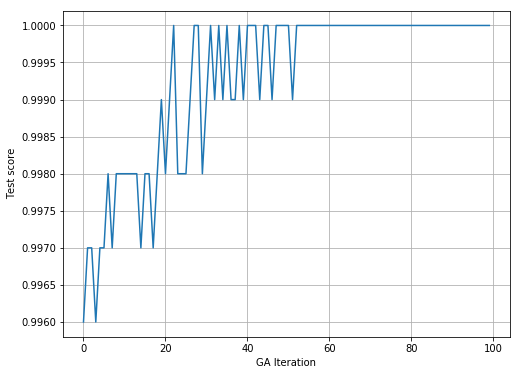

In [52]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(GA.fitness_evolution)
ax.set_xlabel('GA Iteration')
ax.set_ylabel('Test score')
plt.grid()
plt.savefig('GA_SVD_scores.png',dpi=400)

In [53]:
GA.best_fitness

1.0

In [54]:
len(GA.feature_selection.columns)

146

#### Do LOSO on the original feature columns 

In [55]:
X_features = X

sc = StandardScaler()
X_features_scaled = pd.DataFrame(sc.fit_transform(X_features),columns=X_features.columns)
X_features_scaled['activityID'] = feature_df['activityID'].values
X_features_scaled['subjectID'] = feature_df['subjectID'].values

In [56]:
subject_scores_no_selection = LOSO(X_features_scaled,best_classifier)

Holding out subject 5
----------------------------------------------------
             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98        26
        2.0       0.87      0.97      0.92        34
        3.0       1.00      0.77      0.87        31
        4.0       0.97      1.00      0.99        39
        5.0       1.00      0.82      0.90        33
        6.0       1.00      0.96      0.98        28
        7.0       1.00      1.00      1.00        34
       12.0       0.92      1.00      0.96        12
       13.0       0.77      1.00      0.87        10
       16.0       0.96      0.96      0.96        27
       17.0       0.80      0.94      0.87        35
       24.0       1.00      1.00      1.00         5

avg / total       0.95      0.94      0.94       314

----------------------------------------------------
Holding out subject 3
----------------------------------------------------
             precision    recall  f1-score   support

In [57]:
subject_scores_no_selection

{'1.0': 0.8090277777777778,
 '2.0': 0.9654088050314465,
 '3.0': 0.9660194174757282,
 '4.0': 0.9685314685314685,
 '5.0': 0.9394904458598726,
 '6.0': 0.9646302250803859,
 '7.0': 0.9783393501805054,
 '8.0': 0.8307692307692308,
 '9.0': 1.0}

In [58]:
mean_LOSO_no_selection = np.mean([subject_scores_no_selection[e] for e in list(subject_scores_no_selection.keys())])

#### Do LOSO on the feature columns selected by the GA

In [59]:
new_features_GA = list(GA.feature_columns) + ['activityID','subjectID']
X_feature_select_GA = feature_df[new_features_GA]

sc = StandardScaler()
X_feature_select_GA_scaled = pd.DataFrame(sc.fit_transform(X_feature_select_GA),columns=X_feature_select_GA.columns)
X_feature_select_GA_scaled['activityID'] = X_feature_select_GA['activityID'].values
X_feature_select_GA_scaled['subjectID'] = X_feature_select_GA['subjectID'].values

In [60]:
subject_scores_GA_selection = LOSO(X_feature_select_GA_scaled,best_classifier)

Holding out subject 3
----------------------------------------------------
             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98        25
        2.0       0.82      1.00      0.90        33
        3.0       0.95      0.78      0.86        23
        4.0       1.00      1.00      1.00        34
       12.0       1.00      1.00      1.00         9
       13.0       1.00      1.00      1.00        12
       16.0       0.97      1.00      0.98        28
       17.0       1.00      0.92      0.96        37

avg / total       0.96      0.96      0.96       201

----------------------------------------------------
Holding out subject 2
----------------------------------------------------
             precision    recall  f1-score   support

        1.0       1.00      0.93      0.96        29
        2.0       0.93      0.88      0.90        32
        3.0       0.91      1.00      0.95        31
        4.0       1.00      1.00      1.00        4

In [61]:
subject_scores_GA_selection

{'1.0': 0.8090614886731392,
 '2.0': 0.9703947368421053,
 '3.0': 0.9552238805970149,
 '4.0': 0.9826989619377162,
 '5.0': 0.9650793650793651,
 '6.0': 0.9537953795379538,
 '7.0': 0.9550561797752809,
 '8.0': 0.8106508875739645,
 '9.0': 1.0}

In [62]:
mean_LOSO_GA = np.mean([subject_scores_GA_selection[e] for e in list(subject_scores_GA_selection.keys())])

#### Compare final scores

In [63]:
print('Mean LOSO score for GA-based selection: %0.3f' %mean_LOSO_GA)
print('Mean LOSO score for no feature selection: %0.3f' %mean_LOSO_no_selection)

Mean LOSO score for GA-based selection: 0.934
Mean LOSO score for no feature selection: 0.936


Conclusion: GA selection of optimal columns improves the scores in the traditional train-test split learning task, but has ne effect on the LOSO test